In [87]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from pgmpy.models import BayesianNetwork, LinearGaussianBayesianNetwork
from pgmpy.estimators import MaximumLikelihoodEstimator, ExpectationMaximization, BayesianEstimator
from pgmpy.estimators import HillClimbSearch, BicScore, K2Score, BDsScore
import matplotlib.pyplot as plt
from pgmpy.inference import VariableElimination
import networkx as nx

In [88]:
def visualise(model, pos, projectile_color="skyblue", interceptor_color="lightcoral"):
    edges = model.edges()

    # Create a directed graph object
    G = nx.DiGraph()

    # Add edges to the graph
    G.add_edges_from(edges)

    # Create a color map based on node type
    color_map = []
    for node in G.nodes():
        if "P_" in node:
            color_map.append(projectile_color)
        elif "I_" in node:
            color_map.append(interceptor_color)
        else:
            color_map.append("gray")  # Default color for any other nodes

    # Plot the graph with custom positions and colors
    plt.figure(figsize=(20, 12))
    nx.draw(G, pos, with_labels=True, node_size=1000, node_color=color_map, font_size=8, font_weight="bold", arrowsize=10)
    plt.title("Bayesian Network Graph")
    plt.show()

In [89]:
# Define positions manually
pos = {}

for i in range(6):

    if i % 2 == 0:
        # Projectile nodes positions (lower row)
        pos[f'P_FP{i}'] = ((i * 3)  , 0)
        pos[f'P_D{i}'] = ((i * 3 - 1)  , -1)
        pos[f'P_V{i}'] = ((i * 3 + 1)  , -1)
        pos[f'P_IP{i}'] = ((i * 3 - 1)  , -2)
        pos[f'P_A{i}'] = ((i * 3 + 1)  , -2)

        # Interceptor nodes positions (upper row)
        pos[f'I_FP{i}'] = (i * 3, 3)
        pos[f'I_D{i}'] = (i * 3 - 1, 2)
        pos[f'I_V{i}'] = (i * 3 + 1, 2)
        pos[f'I_IP{i}'] = (i * 3 - 1, 1)
        pos[f'I_A{i}'] = (i * 3 + 1, 1)
    else:
         # Projectile nodes positions (lower row)
        pos[f'P_FP{i}'] = ((i * 3)  , (0) - 1)
        pos[f'P_D{i}'] = ((i * 3 - 1)  ,( -1) - 1)
        pos[f'P_V{i}'] = ((i * 3 + 1)  , (-1) - 1)
        pos[f'P_IP{i}'] = ((i * 3 - 1)  , (-2) - 1)
        pos[f'P_A{i}'] = ((i * 3 + 1)  , (-2) - 1)

        # Interceptor nodes positions (upper row)
        pos[f'I_FP{i}'] = (i * 3, (3) + 1)
        pos[f'I_D{i}'] = (i * 3 - 1, (2) + 1)
        pos[f'I_V{i}'] = (i * 3 + 1, (2) + 1)
        pos[f'I_IP{i}'] = (i * 3 - 1, (1) + 1)
        pos[f'I_A{i}'] = (i * 3 + 1, (1) + 1)


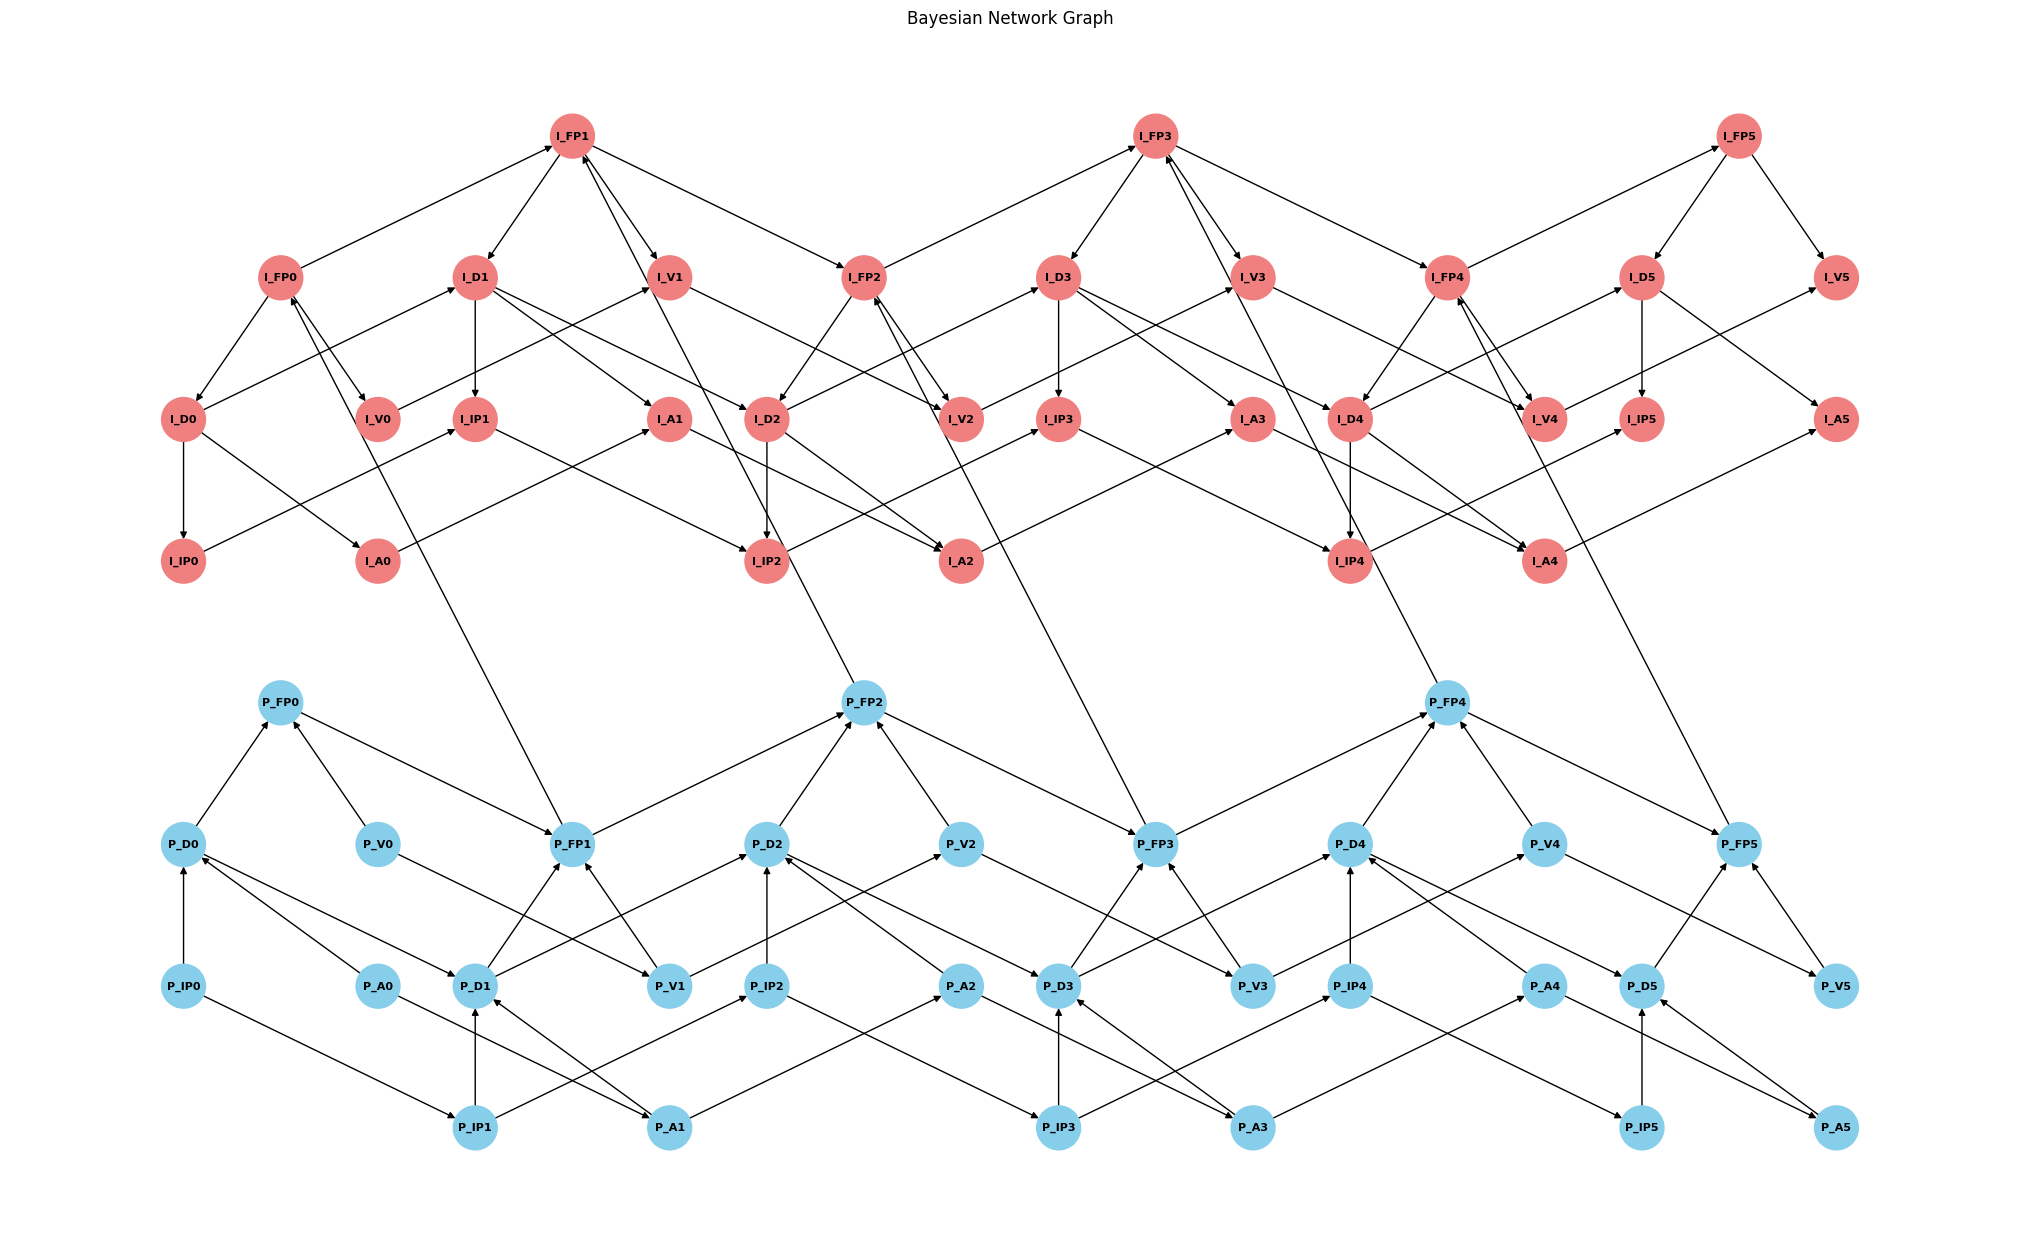

In [90]:
from pgmpy.factors.continuous import LinearGaussianCPD
from pgmpy.models import LinearGaussianBayesianNetwork

# Initialize the Bayesian Network model
GT = LinearGaussianBayesianNetwork()

for i in range(6):
    GT.add_nodes_from([
        f'P_FP{i}', f'P_D{i}', f'P_V{i}',
        f'P_IP{i}', f'P_A{i}',
        f'I_FP{i}', f'I_D{i}', f'I_V{i}',
        f'I_IP{i}', f'I_A{i}'
    ])
    
    GT.add_edges_from([
        ( f'P_D{i}', f'P_FP{i}'),
        (f'P_IP{i}', f'P_D{i}'),
        (f'P_A{i}', f'P_D{i}'),
        ( f'P_V{i}',f'P_FP{i}'),
        ( f'I_FP{i}', f'I_D{i}'),
        (f'I_D{i}',f'I_IP{i}'),
        (f'I_D{i}',f'I_A{i}'),
        ( f'I_FP{i}',f'I_V{i}')
    ])

    if i < 5:
        # Connect corresponding nodes between time slices
        GT.add_edges_from([
            (f'P_FP{i}', f'P_FP{i + 1}'),
            (f'P_D{i}', f'P_D{i + 1}'),
            (f'P_V{i}', f'P_V{i + 1}'),
            (f'P_IP{i}', f'P_IP{i + 1}'),
            (f'P_A{i}', f'P_A{i + 1}'),
            (f'I_FP{i}', f'I_FP{i + 1}'),
            (f'I_D{i}', f'I_D{i + 1}'),
            (f'I_V{i}', f'I_V{i + 1}'),
            (f'I_IP{i}', f'I_IP{i + 1}'),
            (f'I_A{i}', f'I_A{i + 1}')
        ])
        
        # Edge between interceptor and projectile across time slices
        GT.add_edge(f'P_FP{i + 1}', f'I_FP{i}')

visualise(GT, pos)


In [91]:
# CPDs for Projectile Nodes
for i in range(6):
    if i == 0:
        cpd_P_FP = LinearGaussianCPD(
            f'P_FP{i}', 
            [5.0, 0.9, 0.7],  # Assuming offset is replaced with beta's first value
            2.0, 
            [ f'P_V{i}', f'P_D{i}']
        )

        cpd_P_D = LinearGaussianCPD(
            f'P_D{i}', 
            [0.0, 0.5, 0.3],  # Assuming offset is replaced with beta's first value
            0.5,
            [f'P_A{i}', f'P_IP{i}']
        )

        cpd_P_V = LinearGaussianCPD(
            f'P_V{i}', 
            [20.0],  # Assuming offset is replaced with beta's first value
            1.0, 
            []
        )

        cpd_P_IP = LinearGaussianCPD(
            f'P_IP{i}',
            [0.0],  # No evidence, so beta is just the offset value
            3000,
            []
        )

        cpd_P_A = LinearGaussianCPD(
            f'P_A{i}',
            [45.0],  # No evidence, so beta is just the offset value
            0.1,
            []
        )
    else:
        cpd_P_FP = LinearGaussianCPD(
            f'P_FP{i}', 
            [5.0, 0.9, 0.7, 0.3],  # Assuming offset is replaced with beta's first value
            2.0, 
            [ f'P_V{i}', f'P_D{i}', f'P_FP{i - 1}']
        )

        cpd_P_D = LinearGaussianCPD(
            f'P_D{i}', 
            [0.0, 0.5, 0.3, 0.3],  # Assuming offset is replaced with beta's first value
            0.5,
            [f'P_A{i}', f'P_IP{i}',  f'P_D{i - 1}']
        )

        cpd_P_V = LinearGaussianCPD(
            f'P_V{i}', 
            [20.0, 0.9],  # Assuming offset is replaced with beta's first value
            1.0, 
            [ f'P_V{i - 1}']
        )

        cpd_P_IP = LinearGaussianCPD(
            f'P_IP{i}',
            [0.0, 0.1],  # No evidence, so beta is just the offset value
            0.1,
            [f'P_IP{i - 1}']
        )

        cpd_P_A = LinearGaussianCPD(
            f'P_A{i}',
            [45.0, 0.1],  # No evidence, so beta is just the offset value
            0.1,
            [f'P_A{i - 1}']
        )


    # Add CPDs to the network
    GT.add_cpds(cpd_P_FP, cpd_P_D, cpd_P_V, cpd_P_IP, cpd_P_A)

# CPDs for Interceptor Nodes
for i in range(6):

    if i == 0:

        if i < 5:
            cpd_I_FP = LinearGaussianCPD(
                f'I_FP{i}', 
                [5.0, 0.9],  # Assuming offset is replaced with beta's first value
                3.0, 
                [f'P_FP{i+1}']
            )
        else:
            cpd_I_FP = LinearGaussianCPD(
                f'I_FP{i}', 
                [5.0],  # Assuming offset is replaced with beta's first value
                3.0, 
                []
            )

        cpd_I_D = LinearGaussianCPD(
            f'I_D{i}', 
            [0.0, 0.5],  # Assuming offset is replaced with beta's first value
            0.5,
            [ f'I_FP{i}']
        )

        cpd_I_V = LinearGaussianCPD(
            f'I_V{i}', 
            [15.0, 0.8],  # Assuming offset is replaced with beta's first value
            1.5, 
            [f'I_FP{i}']
        )

        cpd_I_IP = LinearGaussianCPD(
            f'I_IP{i}',
            [1, 0.1],  # No evidence, so beta is just the offset value
            0.1,
            [f'I_D{i}']
        )

        cpd_I_A = LinearGaussianCPD(
            f'I_A{i}',
            [45.0, 0.1],  # Depends on the projectile's angle
            0.2,
            [f'I_D{i}']
        )

    else:
        if i < 5:
            cpd_I_FP = LinearGaussianCPD(
                f'I_FP{i}', 
                [5.0, 0.9, 0.7],  # Assuming offset is replaced with beta's first value
                3.0, 
                [f'P_FP{i+1}',  f'I_FP{i - 1}']
            )
        else:
            cpd_I_FP = LinearGaussianCPD(
                f'I_FP{i}', 
                [5.0, 0.9],  # Assuming offset is replaced with beta's first value
                3.0, 
                [f'I_FP{i - 1}']
            )

        cpd_I_D = LinearGaussianCPD(
            f'I_D{i}', 
            [0.0, 0.5, 0.3],  # Assuming offset is replaced with beta's first value
            0.5,
            [ f'I_FP{i}', f'I_D{i - 1}']
        )

        cpd_I_V = LinearGaussianCPD(
            f'I_V{i}', 
            [15.0, 0.8, 0.3],  # Assuming offset is replaced with beta's first value
            1.5, 
            [f'I_FP{i}',  f'I_V{i - 1}']
        )

        cpd_I_IP = LinearGaussianCPD(
            f'I_IP{i}',
            [0.0, 0.2, 0.2],  # No evidence, so beta is just the offset value
            0.1,
            [f'I_D{i}' , f'I_IP{i - 1}']
        )

        cpd_I_A = LinearGaussianCPD(
            f'I_A{i}',
            [45.0, 0.1, 0.1],  # Depends on the projectile's angle
            0.2,
            [f'I_D{i}' ,  f'I_A{i - 1}']
        )


    # Add CPDs to the network
    GT.add_cpds(cpd_I_FP, cpd_I_D, cpd_I_V, cpd_I_IP, cpd_I_A)

In [92]:
# Validation
if GT.check_model():
    print("The model is valid!")
else:
    print("The model is not valid. Please check the CPDs and network structure.")


The model is valid!


In [93]:
# import numpy as np
# import pandas as pd

# def sample_from_joint_gaussian(mean, covariance, size=1):
#     """Samples from a joint Gaussian distribution with given mean and covariance."""
#     mean = np.array(mean).flatten()
#     covariance = np.array(covariance)
    
#     if mean.shape[0] != covariance.shape[0]:
#         raise ValueError("Mean and covariance dimensions do not match.")
    
#     return np.random.multivariate_normal(mean, covariance, size=size)

# def forward_sample_from_dbn(JGD, n_samples=1000):
#     """Perform forward sampling from a joint Gaussian distribution."""
#     # Extract mean and covariance from the joint Gaussian distribution
#     mean = JGD.mean.flatten()
#     covariance = JGD.covariance
    
#     # Sample from the joint Gaussian distribution
#     sampled_data = sample_from_joint_gaussian(mean, covariance, size=n_samples)
    
#     # Create a DataFrame from the sampled data
#     sample_df = pd.DataFrame(sampled_data, columns=JGD.variables)
    
#     return sample_df

# # Generate samples
# n_samples = 1000
# print(GT.nodes)
# JGD = GT.to_joint_gaussian()
# samples_df = forward_sample_from_dbn(JGD, n_samples=n_samples)

# # Save to CSV
# samples_df.to_csv("trajectory_data.csv", index=False)
# print(f"Generated {n_samples} samples and saved to trajectory_data.csv")



In [94]:
import numpy as np
import pandas as pd
from pgmpy.models import LinearGaussianBayesianNetwork

def sample_from_lgbn(model, n_samples=1000):
    """Perform forward sampling from a Linear Gaussian Bayesian Network."""
    topological_order = list(model.nodes())
    
    # Initialize an empty DataFrame for storing samples
    samples_df = pd.DataFrame(index=range(n_samples), columns=topological_order)

    for node in topological_order:
        cpd = model.get_cpds(node)

        # Mean and variance of the CPD
        mean = np.array(cpd.mean).flatten()
        variance = np.array(cpd.variance).flatten()

        if len(mean) != 1 and len(variance) != 1:
            raise ValueError(f"Mean and variance for node {node} must be scalar or match dimensions.")

        if not cpd.evidence:
            # Node has no parents, sample directly
            samples_df[node] = np.random.normal(loc=mean[0], scale=np.sqrt(variance), size=n_samples)
        else:
            # Ensure parent columns are converted to float
            parent_values = samples_df[cpd.evidence].astype(float).values
            # Reshape parent_values to ensure it matches dimensions
            if parent_values.shape[1] != len(mean[1:]):
                print(cpd.variables)
                raise ValueError(f"Number of parent columns ({parent_values.shape[1]}) does not match the number of coefficients ({len(mean[1:])}).")
            
            # Calculate the mean based on the parent's sampled values
            parent_mean = np.dot(parent_values, mean[1:]) + mean[0]
            # Sample from the Gaussian distribution
            samples_df[node] = np.random.normal(loc=parent_mean, scale=np.sqrt(variance), size=n_samples)

    return samples_df

# Example usage:
n_samples = 1000
samples_df = sample_from_lgbn(GT, n_samples=n_samples)

# Save to CSV
samples_df.to_csv("trajectory_data.csv", index=False)
print(f"Generated {n_samples} samples and saved to trajectory_data.csv")




Generated 1000 samples and saved to trajectory_data.csv


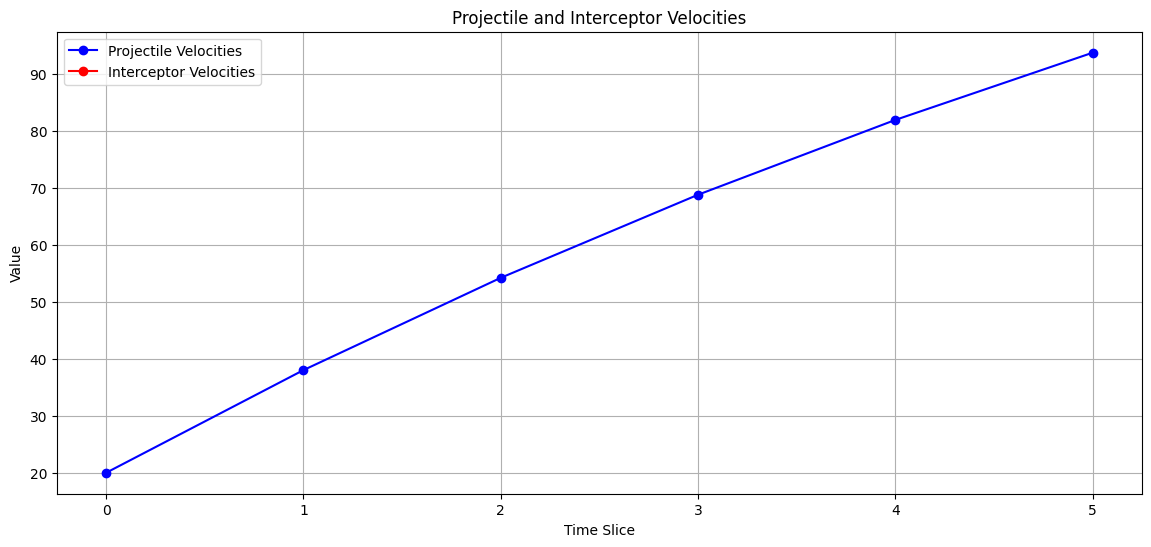

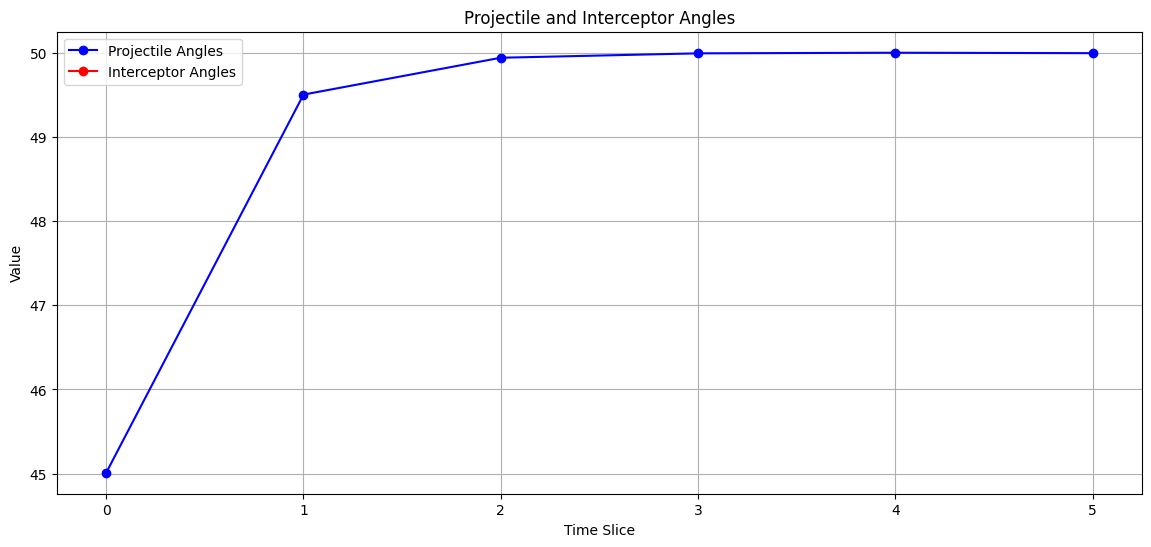

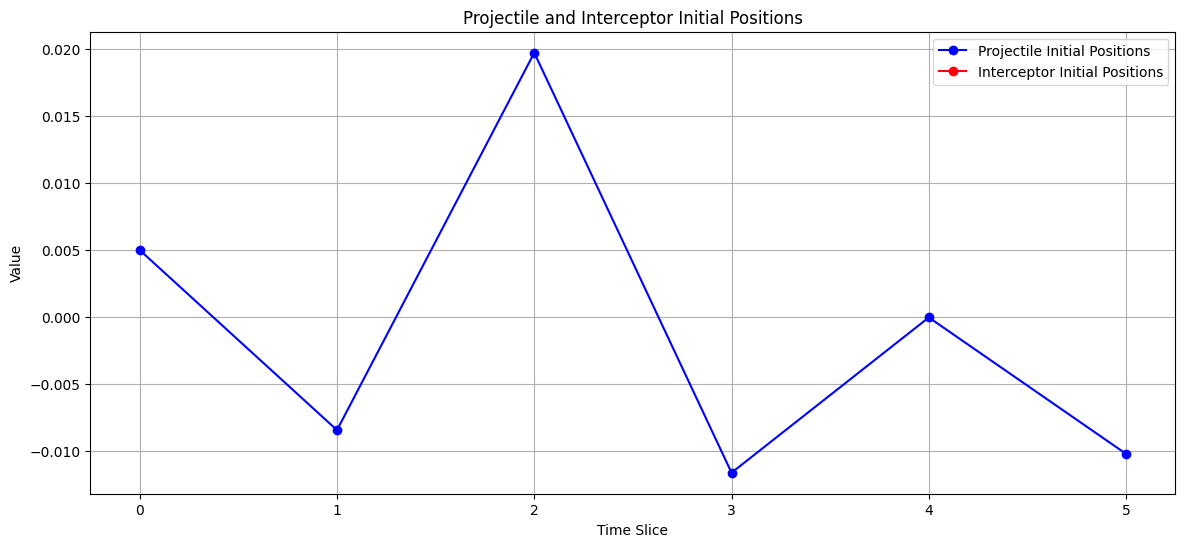

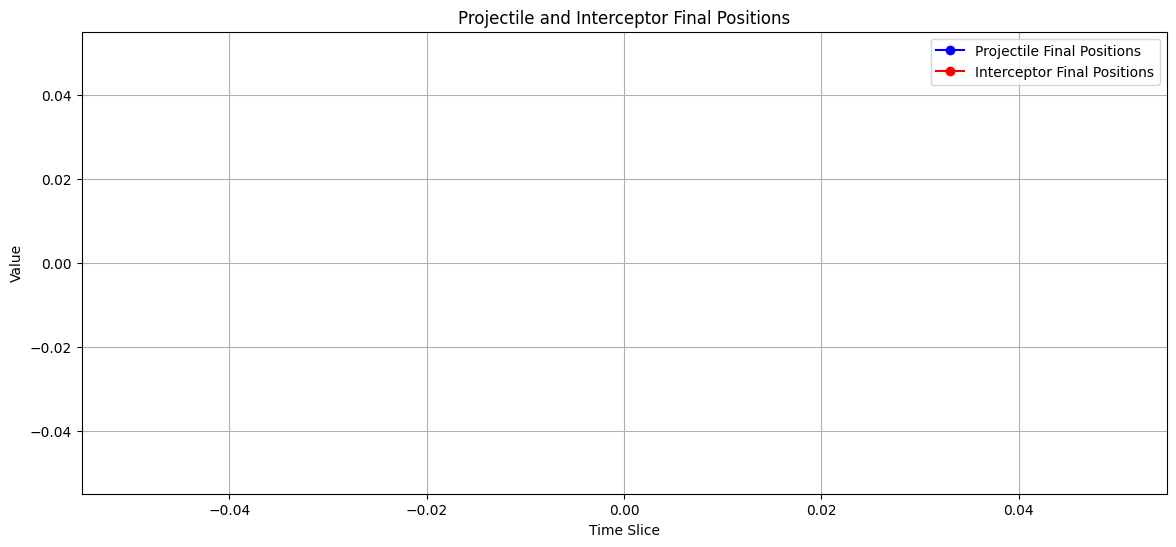

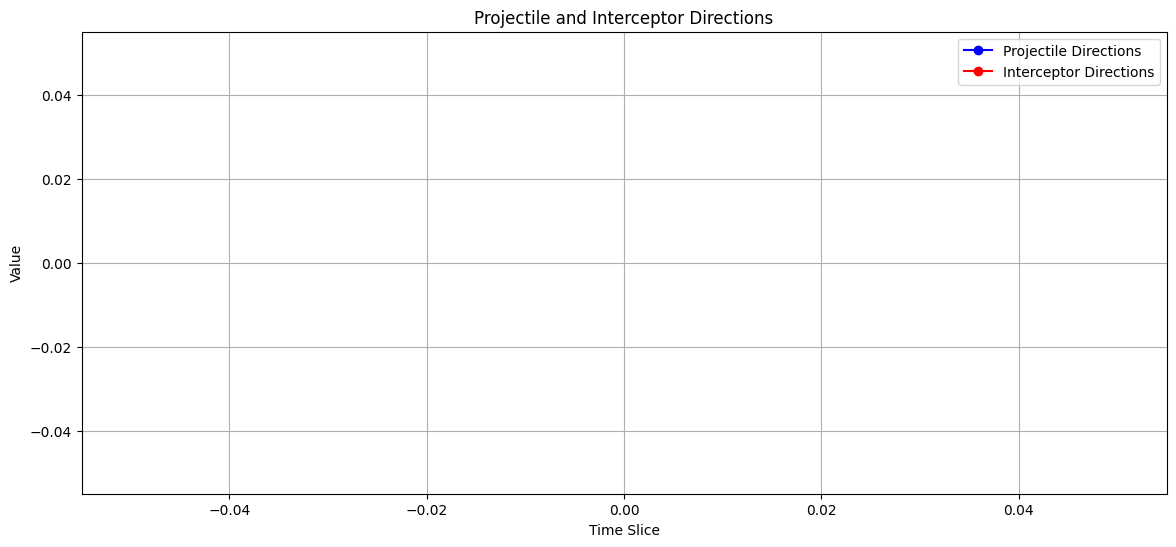

In [95]:
import pandas as pd
import matplotlib.pyplot as plt

# Read the CSV file
file_path = 'trajectory_data.csv'  # Replace with your CSV file path
data = pd.read_csv(file_path)

# Convert all columns to numeric, forcing non-numeric values to NaN
data = data.apply(pd.to_numeric, errors='coerce')

# Define time slices
time_slices = [0, 1, 2, 3, 4, 5]

# Define columns to plot for velocities and angles
projectile_velocities = ['P_V0', 'P_V1', 'P_V2', 'P_V3', 'P_V4', 'P_V5']
interceptor_velocities = ['I_V0', 'I_V1', 'I_V2', 'I_V3', 'I_V4', 'I_V5']
projectile_angles = ['P_A0', 'P_A1', 'P_A2', 'P_A3', 'P_A4', 'P_A5']
interceptor_angles = ['I_A0', 'I_A1', 'I_A2', 'I_A3', 'I_A4', 'I_A5']
projectile_ips = [f'P_IP{i}' for i in range(6)]
projectile_fps = [f'P_FP{i}' for i in range(6)]
projectile_ds = [f'P_D{i}' for i in range(6)]
interceptor_ips = [f'I_IP{i}' for i in range(6)]
interceptor_fps = [f'I_FP{i}' for i in range(6)]
interceptor_ds = [f'I_D{i}' for i in range(6)]

# Function to plot velocities or angles
def plot_values(data, projectile_columns, interceptor_columns, title, label):
    plt.figure(figsize=(14, 6))
    
    # Plot projectile velocities
    plt.plot(time_slices, data[projectile_columns].mean(axis=0), marker='o', label='Projectile ' + label, color='blue')
    
    # Plot interceptor velocities
    plt.plot(time_slices, data[interceptor_columns].mean(axis=0), marker='o', label='Interceptor ' + label, color='red')
    
    plt.xlabel('Time Slice')
    plt.ylabel('Value')
    plt.title(title)
    plt.legend()
    plt.grid(True)

# Plot velocities for projectile and interceptor
plot_values(data, projectile_velocities, interceptor_velocities, 'Projectile and Interceptor Velocities', "Velocities")
plt.show()

# Plot angles for projectile and interceptor
plot_values(data, projectile_angles, interceptor_angles, 'Projectile and Interceptor Angles', "Angles")
plt.show()

# Plot velocities for projectile and interceptor
plot_values(data, projectile_ips, interceptor_ips, 'Projectile and Interceptor Initial Positions', "Initial Positions")
plt.show()

# Plot angles for projectile and interceptor
plot_values(data, projectile_fps, interceptor_fps, 'Projectile and Interceptor Final Positions', "Final Positions")
plt.show()

# Plot velocities for projectile and interceptor
plot_values(data, projectile_ds, interceptor_ds, 'Projectile and Interceptor Directions', "Directions")
plt.show()



In [96]:
import numpy as np

# Function to sample and split coordinates
def sample_and_extract(cpd, mean_vector, variance):
    # Sample from Gaussian distribution
    sampled_vector = np.random.normal(mean_vector, np.sqrt(variance), size=(1, 4))
    
    # Assuming the first two values are x and the last two are y
    x_coords = sampled_vector[0][0:2]  # Extract x components
    y_coords = sampled_vector[0][2:4]  # Extract y components

    return x_coords, y_coords

# Example means and variance
mean_vector_projectile = [0.0, 0.5, 0.3, 0.2]
variance_projectile = 0.5

mean_vector_interceptor = [0.0, 0.5, 0.3, 0.2]
variance_interceptor = 0.5

# Sample and extract for projectile and interceptor
x_p, y_p = sample_and_extract(cpd_P_Pos, mean_vector_projectile, variance_projectile)
x_i, y_i = sample_and_extract(cpd_I_Pos, mean_vector_interceptor, variance_interceptor)

print("Projectile X Coordinates:", x_p)
print("Projectile Y Coordinates:", y_p)
print("Interceptor X Coordinates:", x_i)
print("Interceptor Y Coordinates:", y_i)


NameError: name 'cpd_P_Pos' is not defined